# MAJ : 
1. err_fast pour als et her_als, ok.
2. err_rand_fast pour CPRAND, cette fonction prend la même idée que err_fast, mais en échantillonant. Data fitting error très mauvais si on prend le même échantillon que l'étape random least square calculation. Même si on prend n_samples = 400, ça marche pas.
3. CPRAND avec err_rand, avec n_samples=400, ça marche. (cf article CPRAND Stopping criteria). 
3. her_CPRAND : première version calcul d'erreur avec V,M en échantillonant.  
   Deuxième version calcul d'erreur avec err_rand (j'ai gardé la même echantillon pour calculer les erreurs).
5. comparaison avec le temps
6. comparaison avec les factors plus compliqués

Questions : 
0. err_rand / err_rand_fast 
2.  condition number to 100?

In [1]:
pip install -U tensorly

     |████████████████████████████████| 112kB 2.6MB/s 
     |████████████████████████████████| 163kB 8.4MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.0-cp36-none-any.whl size=143028 sha256=1d41a27306a8df82aa011fb039379dab41a2c4845eecb65ae2438acbe17a445f
  Stored in directory: /root/.cache/pip/wheels/29/54/bc/46d12f7739ad709844b21801e3a91127bc91002111448e3572
Successfully built tensorly


In [2]:
import numpy as np

In [3]:
import tensorly as tl

In [4]:
import matplotlib.pyplot as plt

In [5]:
from tensorly.decomposition import parafac

In [6]:
from tensorly.decomposition import sample_khatri_rao

In [7]:
from scipy.optimize import linear_sum_assignment

In [8]:
from statistics import median

In [9]:
import time

# Basic operations

### Creation of tensors

In [ ]:
# create a random 3x3x3 tensor
t_rand = np.random.random((3, 3, 3))

In [ ]:
# create a constant 3x4x2 tensor
t_cons = tl.tensor(np.arange(24,dtype='d').reshape((3, 4, 2)))

In [ ]:
# create a kruskal tensor
# factor matrices
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))
weights_cp,factors_cp=tl.cp_normalize((None,factors))

In [ ]:
t_krus

array([[[ 534,  630],
        [ 684,  807]],

       [[1980, 2346],
        [2562, 3036]],

       [[3426, 4062],
        [4440, 5265]]])

In [ ]:
factors[0]

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [ ]:
factors[1]

array([[ 9, 10, 11],
       [12, 13, 14]])

In [ ]:
factors[2]

array([[15, 16, 17],
       [18, 19, 20]])

In [ ]:
t_cons

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]])

In [ ]:
# squared Frobenius norm 
tl.norm(t_cons,2)**2

4323.999999999999

In [ ]:
# show frontal slices
t_cons[..., 0]

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]])

In [ ]:
t_cons[..., 1]

array([[ 1.,  3.,  5.,  7.],
       [ 9., 11., 13., 15.],
       [17., 19., 21., 23.]])

### Unfolding

In [ ]:
# mode-1 unfolding (i.e. zeroth mode)
unfolded = tl.unfold(t_cons, mode=0)

In [ ]:
print(unfolded)

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]]


In [ ]:
# refold the unfolded tensor
tl.fold(unfolded, mode=0, shape=t_cons.shape)

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]])

### Other basic operations

In [ ]:
# dimension of tensor
tl.shape(t_rand)

(3, 3, 3)

# Decomposition

### ALS

In [10]:
# stopping criteria 
def err(tensor,weight,factors): 
  t_tilde=tl.kruskal_to_tensor((weight,factors)) # transform tensor decomposition (kruskal tensor) to tensor
  return(tl.norm(tensor-t_tilde))

In [11]:
def err_fast(norm_tensor,A,V,W):
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=res-2*sum(sum(W*A))
  return(np.sqrt(norm_tensor**2+res))

In [12]:
def err_fac(fac,fac_est) :
  weights,fac=tl.cp_normalize((None,fac))
  weights_est,fac_est=tl.cp_normalize((None,fac_est))
  err=0
  for i in range(len(fac)):
    row_ind, col_ind = linear_sum_assignment(-np.dot(np.transpose(fac[i]),fac_est[i]))
    err=err+(tl.norm(fac[i]-fac_est[i][:,col_ind])/tl.norm(fac[i]))
  return(err/len(fac))

In [114]:
# ALS method to compute tensor decomposition
def als(tensor,rank,it_max=100,tol=1e-5,list_factors=False,error_fast=True,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[] # factor matrices
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[] # list of factor matrices
  # Initializtion of factor matrices by left singular vectors
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) # first rank eigenvectors/values (ascendent)
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  # sometimes we have singular matrix error
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors)) # normalise factor matrices
  if list_factors==True : list_fac.append(factors)
  it=0
  error=[err(tensor,weights,factors)/norm_tensor]
  while (error[len(error)-1]>tol and it<it_max):
    if time_rec == True : tic=time.time() 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors[i]),factors[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors), n) # do I need to reverse factors ? --> no deja bon ordre (même matricization que dans le chapitre)
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    if list_factors==True : list_fac.append(factors)
    it=it+1
    if(error_fast==False) : error.append(err(tensor,weights,factors)/norm_tensor)
    else : error.append(err_fast(norm_tensor,factors[N-1],V,W)/norm_tensor)
    if time_rec == True : 
      toc=time.time() 
      list_time.append(toc-tic)
  if list_factors==True and time_rec==True: return(weights,factors,it,error,list_fac,list_time)
  if time_rec==True : return(weights,factors,it,error,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  return(weights,factors,it,error)

#### Test

In [ ]:
# test err
tensor=tl.tensor(np.arange(12,dtype='d').reshape((3, 2, 2)))
err(tensor,None,factors) # with factors of t_krus

NameError: ignored

##### Test als random tensor

In [ ]:
# test als with a random tensor, rank = 3 (order)
weights,factors,it,error=als(t_rand,3)
tl.kruskal_to_tensor((weights,factors))

In [ ]:
it

In [ ]:
# compare with parafac in tensorly
kt=parafac(t_rand,3)
tl.kruskal_to_tensor(kt)

In [ ]:
# compare with the initial tensor
t_rand

In [ ]:
# test als with a random tensor, rank = 100
weights,factors,it,error=als(t_rand,100)
tl.kruskal_to_tensor((weights,factors))

In [ ]:
weights,factors,it,error=als(tensor,3)

In [ ]:
it

In [ ]:
error

In [ ]:
tl.kruskal_to_tensor((weights,factors))

In [ ]:
tensor

##### Test als cp tensor

In [ ]:
# test als with the Kurskal tensor in section Basic operations
np.random.seed(1)
weights,factors,it,error1,l=als(t_krus,3,list_factors=True)
it

In [ ]:
np.random.seed(1)
weights,factors,it,error,l=als(t_krus,3,list_factors=True,error_fast=False)
it

In [ ]:
tl.kruskal_to_tensor((weights,factors))

In [ ]:
# compare with the initial tensor
t_krus

We obtain the same tensor, but not the same decomposition (weights and factors are different from the definition of t_krus), because of permutation and normalization.

In [ ]:
# Test err_fac
err_fac(factors_cp,factors)

In [ ]:
# with another random cp_tensor
A=np.random.random((3, 3))
B=np.random.random((2, 3))
C=np.random.random((2, 3))
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))
weights_cp,factors_cp=tl.cp_normalize((None,factors))

In [ ]:
weights,factors,it,error=als(t_krus,3)
it

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
t_krus

In [ ]:
err_fac(factors_cp,factors)

In [ ]:
cp_para=parafac(t_krus,3)

In [ ]:
err_fac(factors_cp,cp_para.factors)

In [ ]:
tl.cp_to_tensor(cp_para)

### her_Als

In [112]:
def her_Als(tensor,rank,it_max=100,err_it_max=20,tol=1e-5,beta=0.5,eta=1.5,gamma=1.05,gamma_bar=1.01,list_factors=False,error_fast=True,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u] 
  # Initialization of factor hat matrices by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)

  it=0
  err_it=0
  cpt=0
  F_hat_bf=err(tensor,None,factors) # cost
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]

  while (min_err > tol and it<it_max and err_it<err_it_max):
    if time_rec == True : tic=time.time()
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors_hat[i]),factors_hat[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors_hat), n) 
      factor_bf=factors[n]
      # update
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    if(error_fast==False) : F_hat_new = err(tensor,None,factors_hat) # cost update 
    else : F_hat_new = err_fast(norm_tensor,factors[N-1],V,W)
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(F_hat_new/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  weights,factors=tl.cp_normalize((None,factors))
  if time_rec == True and list_factors==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec == True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)


#### Test

In [ ]:
np.random.seed(1)
weights,factors,it,error,cpt=her_Als(t_krus,3)
it

In [ ]:
np.random.seed(1)
weights,factors,it,error,cpt=her_Als(t_krus,3,error_fast=False)
it

In [ ]:
cpt

In [ ]:
tl.kruskal_to_tensor((weights,factors))

### CPRAND

#### Stopping criteria

In [15]:
# Stopping criteria of CPRAND
def err_rand(tensor,weights,factors,nb_samples,indices_list=None): 
  if indices_list==None : 
    indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
    indices_list = [i.tolist() for i in indices_list]
    indices_list = tuple(indices_list)
  est_values=[]
  P=1
  for i in tl.shape(tensor) : P=P*i
  for i in range(nb_samples):
     if weights is None : value=1
     else : value=weights
     for mode in range(tl.ndim(tensor)) :
       value=value*factors[mode][indices_list[mode][i],:]
     est_values+=[sum(value)]
  list_e=(tensor[indices_list]-est_values)**2  # max(list_e) = 1 (general ? mais si les donnees sont grandes ?)
  return(np.sqrt(sum(list_e)*P/nb_samples),indices_list) 

In [16]:
def err_rand_fast(tensor,A,V,W,nb_samples,indices_list=None): 
  if indices_list==None : 
    indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
    indices_list = [i.tolist() for i in indices_list]
    indices_list = tuple(indices_list)
  norm_tensor=tl.norm(tensor[indices_list])
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=norm_tensor**2+res-2*sum(sum(W*A)) 
  res=np.sqrt(res)/nb_samples
  P=1
  for i in tl.shape(tensor) : P=P*i
  return(res*P,indices_list) 

##### Test for err

In [ ]:
indices_list=[np.random.randint(0, tl.shape(m)[0], size=4, dtype=int) for m in factors]

In [ ]:
indices_list = [i.tolist() for i in indices_list]
indices_list = tuple(indices_list) 
indices_list

In [ ]:
t_krus[indices_list] 

In [ ]:
est_values=[]
for i in range(4) : # P 
  value=weights
  for mode in range(tl.ndim(t_krus)) : 
     value=value*factors[mode][indices_list[mode][i],:]
  est_values+=[sum(value)]

In [ ]:
est_values

In [ ]:
err_rand(t_krus,weights,factors,4)[0]

#### Main method

In [137]:
# version 1 variance trop grande : error comme dans her, mais les matrices V,W et la norme tensor etantes randomisees.
def CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-6,list_factors=False,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if time_rec == True : list_time=[]
  # Initializtion of factor matrices 
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(factors) 

  it=0
  err_it=0
  ########################################
  ######### error initialization #########
  ########################################
  if(exact_err==False):
    temp,ind_err=err_rand(tensor,weights,factors,400) 
    error=[temp/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]

  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec == True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tensor[indices_list]
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      V=tl.dot(tl.transpose(Zs),Zs)
      W=tl.dot(sampled_unfolding,Zs)
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix
    
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    if list_factors==True : list_fac.append(factors)
    it=it+1
    ################################
    ######### error update #########
    ################################
    if(exact_err==False):
      error.append(err_rand_fast(tensor,factors[N-1],V,W,n_samples,indices_list)[0]/norm_tensor) # same indices used as for Random Lesat Square Calculation
    else : error.append(err(tensor,weights,factors)/norm_tensor)

    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  if time_rec == True and list_factors==True: return(weights,factors,it,error,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  if time_rec==True : return(weights,factors,it,error,list_time)
  return(weights,factors,it,error)

In [133]:
# version 2 : error comme dans article CPRAND, ici l'interet est de pouvoir prendre plus d'indices
def CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-6,list_factors=False,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if time_rec == True : list_time=[]

  # Initializtion of factor matrices
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(factors) 

  it=0
  err_it=0
  ########################################
  ######### error initialization #########
  ########################################
  if(exact_err==False):
    temp,ind_err=err_rand(tensor,weights,factors,400)
    error=[temp/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]
  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec == True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tensor[indices_list]
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      V=tl.dot(tl.transpose(Zs),Zs)
      W=tl.dot(sampled_unfolding,Zs)
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix
    
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    if list_factors==True : list_fac.append(factors)
    it=it+1
    ################################
    ######### error update #########
    ################################
    if(exact_err==False):
      temp,ind_err=err_rand(tensor,weights,factors,400,ind_err)
      error.append(temp/norm_tensor)
    else : error.append(err(tensor,weights,factors)/norm_tensor)

    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # min err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  if time_rec == True and list_factors==True: return(weights,factors,it,error,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  if time_rec==True : return(weights,factors,it,error,list_time)
  return(weights,factors,it,error)

#### Test

In [ ]:
rank=3
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error=CPRAND(t_krus,rank,n_samples,exact_err=False)
it

In [ ]:
t_krus

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
weights,factors,it,error=CPRAND(tensor,rank,n_samples,exact_err=True)
it

In [ ]:
tensor

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
error

### her-CPRAND



#### Main method

In [145]:
# exact_err indicates whether we use exact error calculation or randomised error calculation
# list_factors indicates whether we return the list of factors generated at each iteration
# we stop the algorithm if min_err is not updated for err_it_max iterations

def her_CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-6,beta=0.1,eta=2,gamma=1.01,gamma_bar=1.005,list_factors=False,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if(time_rec==True) : list_time=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)
  if time_rec==True : list_err=[]

  it=0
  err_it=0
  cpt=0
  if(exact_err==False):F_hat_bf,a=err_rand(tensor,None,factors,400)
  else : F_hat_bf=err(tensor,None,factors) # exact cost
  rng = tl.random.check_random_state(None)
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec==True :tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      V=tl.dot(tl.transpose(Zs),Zs)
      if (n==0) :sampled_unfolding = tensor[indices_list] 
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      W=tl.dot(sampled_unfolding,Zs)
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    if(exact_err==False): 
      F_hat_bf,a= err_rand_fast(tensor,factor_bf,V,W,n_samples,indices_list)
      F_hat_new,a= err_rand_fast(tensor,factors[N-1],V,W,n_samples,indices_list) 
    else :
      F_hat_new = err(tensor,None,factors_hat) # exact cost update 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    if(exact_err==True) : F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(F_hat_bf/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec==True : 
      toc=time.time()
      list_time.append(toc-tic)
  weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True and time_rec==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec==True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)

In [151]:
# version 2
def her_CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-6,beta=0.1,eta=2,gamma=1.01,gamma_bar=1.005,list_factors=False,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]
  if time_rec==True : list_time=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)

  it=0
  err_it=0
  cpt=0
  ########################################
  ######### error initialization #########
  ########################################
  if(exact_err==False):F_hat_bf,ind_err=err_rand(tensor,None,factors,400)
  else : F_hat_bf=err(tensor,None,factors) # exact cost

  rng = tl.random.check_random_state(None)
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec==True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      V=tl.dot(tl.transpose(Zs),Zs)
      if (n==0) :sampled_unfolding = tensor[indices_list] 
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      W=tl.dot(sampled_unfolding,Zs)
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    ################################
    ######### error update #########
    ################################
    if(exact_err==False): 
      F_hat_new,ind_err= err_rand(tensor,None,factors_hat,400,ind_err) 
    else :
      F_hat_new = err(tensor,None,factors_hat) # exact cost update 
      
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(F_hat_bf/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec==True : 
      toc=time.time()
      list_time.append(toc-tic)
  weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True and time_rec==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec==True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)

##### Test 

###### Test sample_kahtri_rao

In [ ]:
# test sample_kahtri_rao
Zs,indices=tl.decomposition.sample_khatri_rao(factors,2,skip_matrix=1)

In [ ]:
t_krus[...,0]

In [ ]:
t_krus[...,1]

In [ ]:
factors

In [ ]:
tl.tenalg.khatri_rao(factors,skip_matrix=0)

In [ ]:
Zs # line 5 and 3

In [ ]:
indices

In [ ]:
indices_list = [i.tolist() for i in indices]

In [ ]:
indices_list.insert(0, slice(None, None, None))

In [ ]:
indices_list

In [ ]:
indices_list = tuple(indices_list)

In [ ]:
sampled_unfolding = t_krus[indices_list]

In [ ]:
sampled_unfolding

In [ ]:
sampled_unfolding = tl.transpose(t_krus[indices_list])

In [ ]:
tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))

###### Test her_CPRAND

In [ ]:
# with a cp_tensor (order=3)
rank=3
n_samples=int(10*rank*np.log(rank)+1) # pour qu'il soit bien conditionne ?
weights,factors,it,error,cpt=her_CPRAND(t_krus,rank,n_samples,False) 
it 

In [ ]:
cpt

In [ ]:
min(error) 

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
t_krus

In [ ]:
# with a random tensor, order = 4
t_rand = np.random.random((3, 2, 2, 4))
t_rand

In [ ]:
# here rank=3
weights,factors,it,error,cpt=her_CPRAND(t_rand,rank,n_samples) 
it

In [ ]:
cpt

In [ ]:
min(error)

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
# here rank = 100
rank=100
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error,cpt=her_CPRAND(t_rand,rank,n_samples) 
it

In [ ]:
cpt

In [ ]:
tl.cp_to_tensor((weights,factors))

In [ ]:
# here rank=100, n_samples=40
weights,factors,it,error,cpt=her_CPRAND(t_rand,100,40) 

#### Research of optimal parameters

cf P12, 14-15, long article of her.  
y-axis : data fitting error $f-f_{min}$ with exact error calculation (or factors error)  
x-axis : nb iteration

In [19]:
I=50
J=50
K=50
r=10 # rank
n_samples=int(10*r*np.log(r)+1) # nb of randomized samples
nb_rand=10 # nb of random initialization

In [ ]:
def param_research(I,J,K,r,nb_rand,n_samples,exact_err=True,beta=True,eta=False,gamma=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,[A,B,C]))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    # parameter choice
    if(beta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.1) # beta0=0.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.3) # beta0=0.3
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.5) # beta0=0.5
    if(eta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=1.1) # eta=1.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=2) # eta=2
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=3) # eta=3
    if(gamma==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.01,gamma_bar=1.005) 
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.05,gamma_bar=1.01) 
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.9,gamma_bar=1.5) 
    error1=[i * norm_tensor for i in error1]
    list_err1.append(error1)
    error2=[i * norm_tensor for i in error2]
    list_err2.append(error2)
    error3=[i * norm_tensor for i in error3]
    list_err3.append(error3)
    if (min_e>min(min(error1),min(error2),min(error3))) : min_e=min(min(error1),min(error2),min(error3))
  list_err1=[x-min_e for x in list_err1]
  list_err2=[x-min_e for x in list_err2]
  list_err3=[x-min_e for x in list_err3]
  # plot
  for i in range(len(list_err1)):
    plt.plot(range(len(list_err1[i])),list_err1[i],'b-') 
  for i in range(len(list_err2)):
    plt.plot(range(len(list_err2[i])),list_err2[i],'r-') 
  for i in range(len(list_err3)):
    plt.plot(range(len(list_err3[i])),list_err3[i],'g-')
  plt.yscale("log") 

In [ ]:
# with exact_error
param_research(I,J,K,r,nb_rand,n_samples,beta=True,exact_err=True)

In [ ]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,eta=True)

In [ ]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,gamma=True)

# Comparaison of algorithms

In [235]:
def sv_scale_to_100(A):
  u,d,v=np.linalg.svd(A,full_matrices=False)
  scale=99/(d[0]-d[len(d)-1])
  for i in range(len(d)) : d[i]=(d[i]-d[len(d)-1])*scale+1
  d[len(d)-1]=1
  return (u@np.diag(d)@v)

In [244]:
def init_factors(I,J,K,r,scale=False) :
  A=np.random.normal(0, 1, size=(I, r))
  B=np.random.normal(0, 1, size=(J, r))
  C=np.random.normal(0, 1, size=(K, r))
  noise=np.random.normal(0, 0.001, size=(I,J,K))
  if (scale==True) :  
    A=sv_scale_to_100(A)
    B=sv_scale_to_100(B)
    C=sv_scale_to_100(C)
  return (A,B,C,noise)

#### Iterations

##### her_Als and als for 1 tensor

In [248]:
# initialization of a random tensor with noise
A,B,C,noise=init_factors(I*2,J*2,K*2,r)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

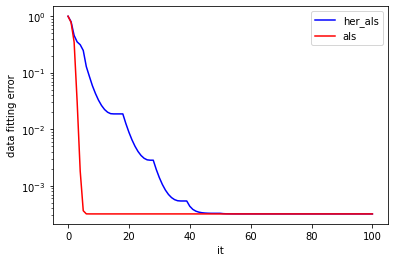

In [249]:
# her als
weights1,factors1,it1,error1,cpt=her_Als(t,r,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(t,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-',label="her_als")
plt.plot(range(len(error2)),error2,'r-',label="als") 
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best')
plt.yscale("log") 

In [ ]:
print("it her als",it1,"it als",it2)

In [242]:
cpt

0.14

In [ ]:
min(error1)

##### CPRAND and als for 1 tensor

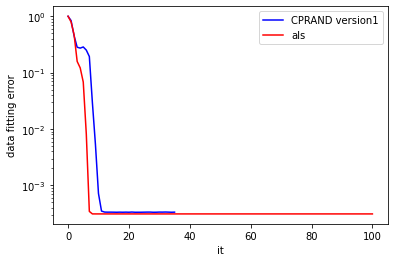

In [40]:
# CPRAND version1
weights1,factors1,it1,error1=CPRAND(t,r,int(10*r*np.log(r)+1),exact_err=True,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(t,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-',label="CPRAND version1")
plt.plot(range(len(error2)),error2,'r-',label="als") 
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best')
plt.yscale("log")

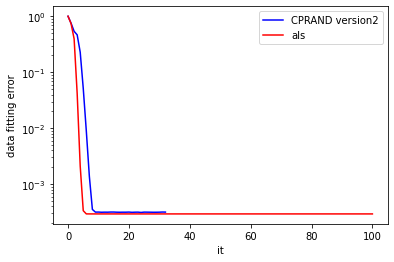

In [29]:
# CPRAND version2
weights1,factors1,it1,error1=CPRAND(t,r,int(10*r*np.log(r)+1),exact_err=True,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(t,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-',label="CPRAND version2")
plt.plot(range(len(error2)),error2,'r-',label="als") 
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best')
plt.yscale("log")

##### her-CPRAND and als for 1 tensor

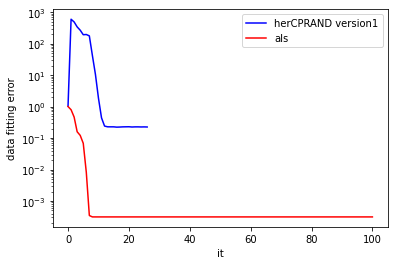

In [36]:
# her CPRAND version1
weights1,factors1,it1,error1,pct=her_CPRAND(t,r,int(10*r*np.log(r)+1),False,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(t,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-',label="herCPRAND version1")
plt.plot(range(len(error2)),error2,'r-',label="als")
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best') 
plt.yscale("log")

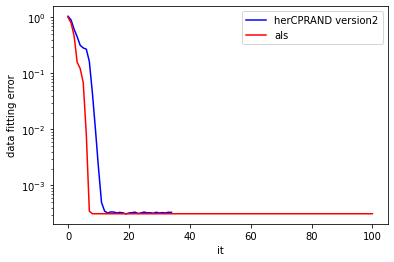

In [38]:
# her CPRAND version2
weights1,factors1,it1,error1,pct=her_CPRAND(t,r,int(10*r*np.log(r)+1),False,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(t,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-',label="herCPRAND version2")
plt.plot(range(len(error2)),error2,'r-',label="als")
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best') 
plt.yscale("log")

##### 3 algorithms for 10 random initializations

In [268]:
# plot the median of data fitting/factors error over nb_rand initializations
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=True,list_factors=False,scale=False):
  list_err1=[]
  list_err2=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    if list_factors ==False : 
      #weights1,factors1,it1,error1,cpt=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200) 
      weights1,factors1,it1,error1,cpt=her_Als(t,r,it_max=500,err_it_max=100) 
      #weights1,factors1,it1,error1=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200) 
      weights2,factors2,it2,error2=als(t,r,it_max=500) 
      error1=[i * norm_tensor for i in error1]
      error2=[i * norm_tensor for i in error2]
    else : 
      #weights1,factors1,it1,error,cpt,l1=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors) 
      weights1,factors1,it1,error,cpt,l1=her_Als(t,r,it_max=500,err_it_max=100,list_factors=list_factors) 
      #weights1,factors1,it1,error,l1=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors) 
      weights2,factors2,it2,error,l2=als(t,r,it_max=500,list_factors=list_factors) 
      error1=[err_fac(fac_true,i) for i in l1]
      error2=[err_fac(fac_true,i) for i in l2]
    if (min_e>min(min(error1),min(error2))) : min_e=min(min(error1),min(error2))
    list_err1.append(error1)
    list_err2.append(error2)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat1=mat1-min_e
  mat2=mat2-min_e
  # plot

  plt.plot(range(n_max1),np.median(mat1, axis=0),'b-',label="her als") 
  plt.plot(range(n_max2),np.median(mat2, axis=0),'r-',label="als") 
  plt.yscale("log") 
  plt.xlabel('it')
  plt.ylabel('datafitting error')
  plt.legend(loc='best')

##### her_Als and als median

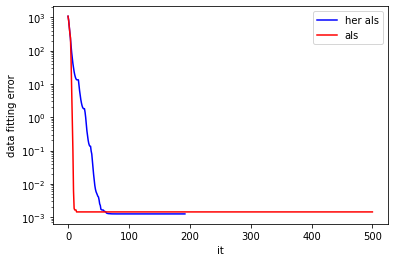

In [44]:
# error_fast==True
comparaison(I,J,K,r,nb_rand,n_samples)
# data-fitting median error : her_Als in blue and als in red

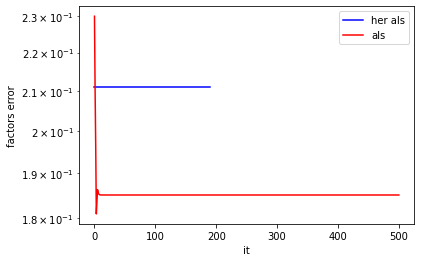

In [47]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True)

##### CPRAND and als

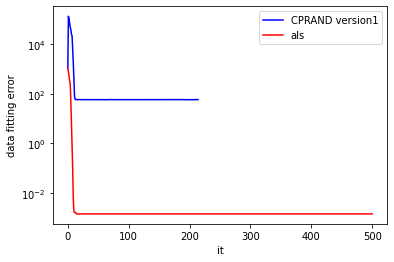

In [52]:
# exact_err == False version 1 but n_samples = 200+
comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False)
# data-fitting median error : CPRAND in blue and als in red

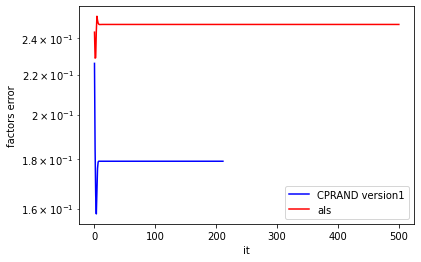

In [50]:
# factors error, exact_err == False version 1 but n_samples = 200+
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True,exact_err=False)

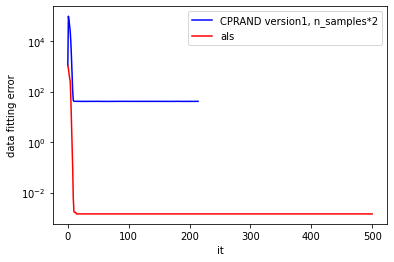

In [54]:
# exact_err == False version 1 but n_samples = 400+
comparaison(I,J,K,r,nb_rand,n_samples*2,exact_err=False)
# data-fitting median error : CPRAND in blue and als in red

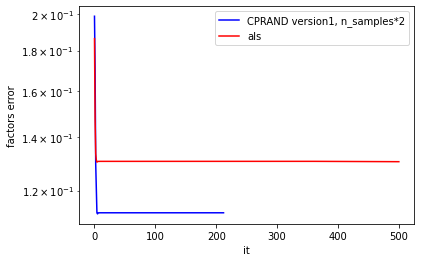

In [56]:
# factors error, exact_err == False version 1 but n_samples = 400+
comparaison(I,J,K,r,nb_rand,n_samples*2,list_factors=True,exact_err=False)

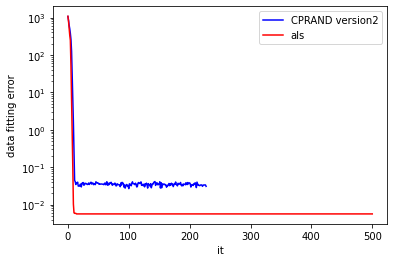

In [61]:
# exact_err == False version 2
comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False)
# data-fitting median error : CPRAND in blue and als in red

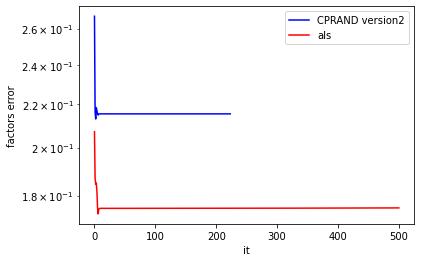

In [59]:
# factors error version 2
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True,exact_err=False)

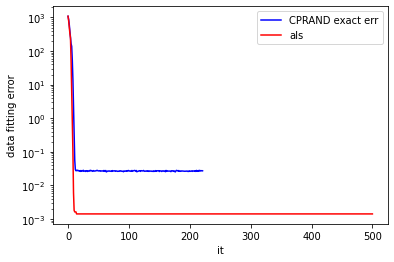

In [63]:
# exact_err == True
comparaison(I,J,K,r,nb_rand,n_samples,exact_err=True)
# data-fitting median error : CPRAND in blue and als in red

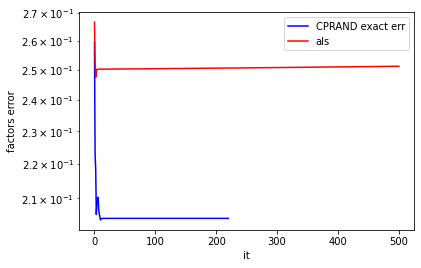

In [65]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True,exact_err=True)

##### her_CPRAND and als

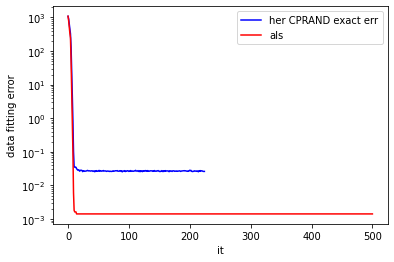

In [69]:
# exact_err=True
comparaison(I,J,K,r,nb_rand,n_samples,True)
# data-fitting median error : her_CPRAND in blue and als in red

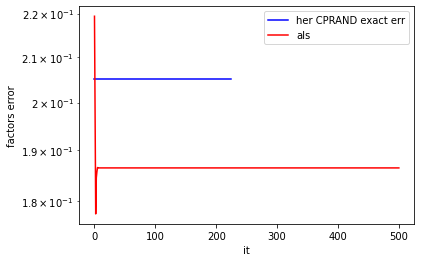

In [67]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,True,list_factors=True)

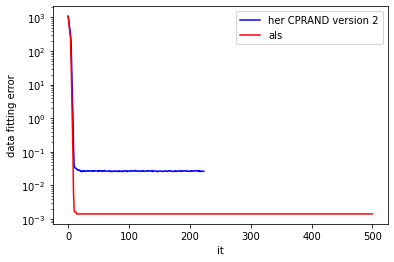

In [72]:
# exact_err=False
comparaison(I,J,K,r,nb_rand,n_samples,True)
# data-fitting median error : her_CPRAND in blue and als in red

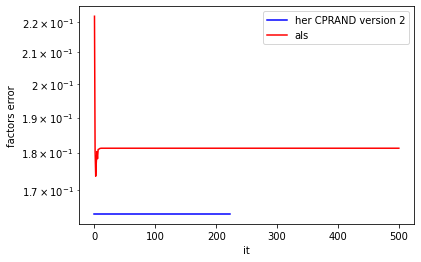

In [251]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True)

#### Time

##### For 1 tensor

In [254]:
# initialization of a random tensor with noise
A,B,C,noise=init_factors(I,J,K,r)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

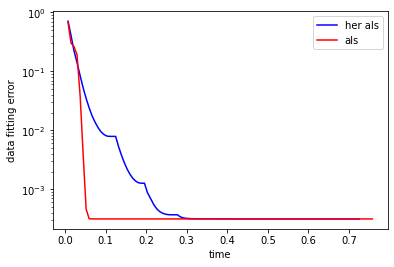

In [255]:
# her als
weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,it_max=100,err_it_max=20,time_rec=True) 
# als
weights2,factors2,it2,error2,time2=als(t,r,it_max=100,time_rec=True)
del error1[0]
del error2[0]
# plot
plt.plot(np.cumsum(time1),error1,'b-',label="her als")
plt.plot(np.cumsum(time2),error2,'r-',label="als") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('data fitting error')
plt.legend(loc='best')

In [157]:
cpt

0.1

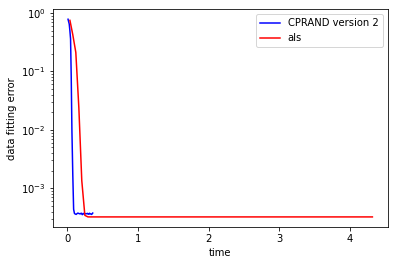

In [79]:
# CPRAND version 2
weights1,factors1,it1,error1,time1=CPRAND(t,r,n_samples=int(10*r*np.log(r)+1),it_max=100,err_it_max=20,time_rec=True) 
# als
weights2,factors2,it2,error2,time2=als(t,r,it_max=100,time_rec=True)
del error1[0]
del error2[0]
# plot
plt.plot(np.cumsum(time1),error1,'b-',label="CPRAND version 2")
plt.plot(np.cumsum(time2),error2,'r-',label="als") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('data fitting error')
plt.legend(loc='best')

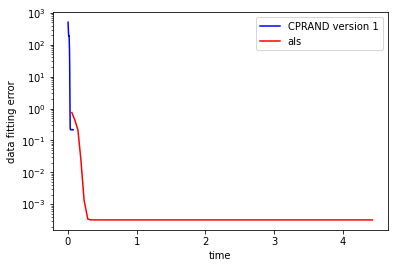

In [81]:
# CPRAND version 1
weights1,factors1,it1,error1,time1=CPRAND(t,r,n_samples=int(10*r*np.log(r)+1),it_max=100,err_it_max=20,time_rec=True) 
# als
weights2,factors2,it2,error2,time2=als(t,r,it_max=100,time_rec=True)
del error1[0]
del error2[0]
# plot
plt.plot(np.cumsum(time1),error1,'b-',label="CPRAND version 1")
plt.plot(np.cumsum(time2),error2,'r-',label="als") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('data fitting error')
plt.legend(loc='best')

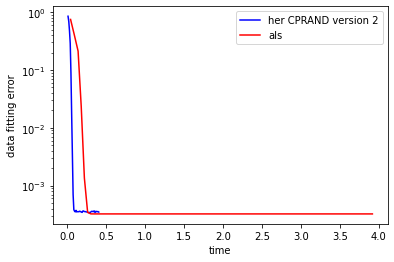

In [160]:
# her CPRAND version 2
weights1,factors1,it1,error1,pct,time1=her_CPRAND(t,r,int(10*r*np.log(r)+1),False,it_max=100,err_it_max=20,time_rec=True) 
# als
weights2,factors2,it2,error2,time2=als(t,r,it_max=100,time_rec=True)
del error1[0]
del error2[0]
# plot
plt.plot(np.cumsum(time1),error1,'b-',label="her CPRAND version 2")
plt.plot(np.cumsum(time2),error2,'r-',label="als") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('data fitting error')
plt.legend(loc='best')

In [161]:
pct

0.32432432432432434

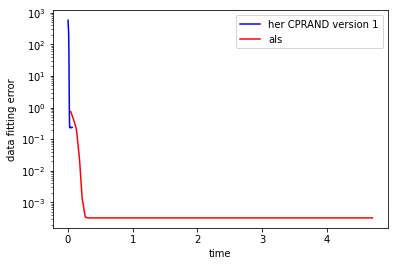

In [90]:
# her CPRAND version 1
weights1,factors1,it1,error1,pct,time1=her_CPRAND(t,r,int(10*r*np.log(r)+1),False,it_max=100,err_it_max=20,time_rec=True) 
# als
weights2,factors2,it2,error2,time2=als(t,r,it_max=100,time_rec=True)
del error1[0]
del error2[0]
# plot
plt.plot(np.cumsum(time1),error1,'b-',label="her CPRAND version 1")
plt.plot(np.cumsum(time2),error2,'r-',label="als") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('data fitting error')
plt.legend(loc='best')

##### 3 algorithms for 10 tensors

In [274]:
def compar_time(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_time1=[]
  list_err2=[]
  list_time2=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    if list_factors ==False : 
      #weights1,factors1,it1,error1,cpt,time1=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,time_rec=True) 
      weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,it_max=500,err_it_max=100,time_rec=True) 
      #weights1,factors1,it1,error1,time1=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,time_rec=True) 
      weights2,factors2,it2,error2,time2=als(t,r,it_max=500,time_rec=True) 
      error1=[i * norm_tensor for i in error1]
      del error1[0]
      error2=[i * norm_tensor for i in error2]
      del error2[0]
    else : 
      #weights1,factors1,it1,error,cpt,l1,time1=her_CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors,time_rec=True) 
      weights1,factors1,it1,error,cpt,l1,time1=her_Als(t,r,it_max=500,err_it_max=100,list_factors=list_factors,time_rec=True) 
      #weights1,factors1,it1,error,l1,time1=CPRAND(t,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors,time_rec=True) 
      weights2,factors2,it2,error,l2,time2=als(t,r,it_max=500,list_factors=list_factors,time_rec=True) 
      error1=[err_fac(fac_true,i) for i in l1]
      del error1[0]
      error2=[err_fac(fac_true,i) for i in l2]
      del error2[0]
    if (min_e>min(min(error1),min(error2))) : min_e=min(min(error1),min(error2))
    list_err1.append(error1)
    list_err2.append(error2)
    list_time1.append(time1)
    list_time2.append(time2)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat1=mat1-min_e
  mat2=mat2-min_e

  t_max1=len(max(list_time1, key=len))
  t_max2=len(max(list_time2, key=len))
  mat_time1=np.array([i + [0]*(t_max1-len(i)) for i in list_time1])
  mat_time2=np.array([i + [0]*(t_max2-len(i)) for i in list_time2])
  # plot

  plt.plot(np.cumsum(np.median(mat_time1, axis=0)),np.median(mat1, axis=0),'b-',label="her als") 
  plt.plot(np.cumsum(np.median(mat_time2, axis=0)),np.median(mat2, axis=0),'r-',label="als") 
  plt.yscale("log") 
  plt.xlabel('time')
  plt.ylabel('data fitting error')
  plt.legend(loc='best')  



###### her als and als

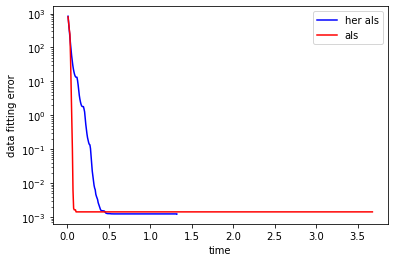

In [128]:
# her als data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

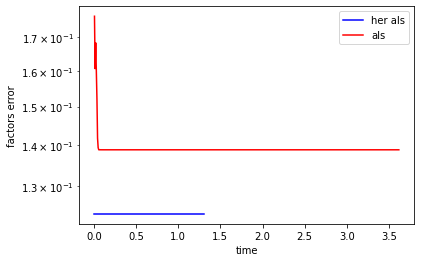

In [132]:
# her als factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

###### CPRAND and als

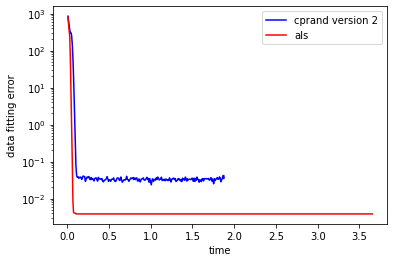

In [136]:
# cprand version 2 data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

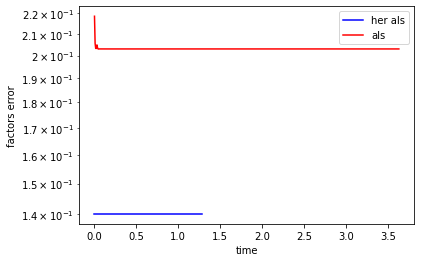

In [134]:
# cprand version 2 factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

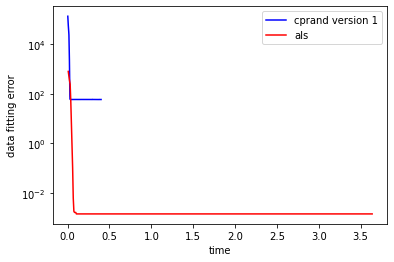

In [144]:
# cprand version 1 data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

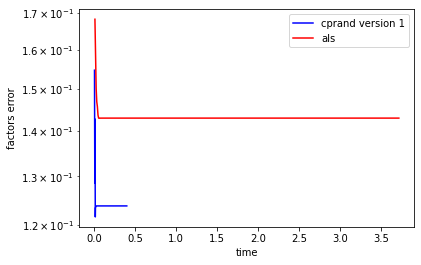

In [142]:
# cprand version 1 factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

###### her CPRAND and als

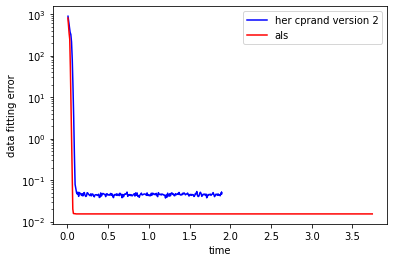

In [257]:
# her cprand version 2 data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

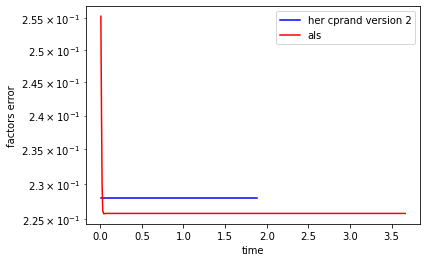

In [153]:
# her cprand version 2 factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

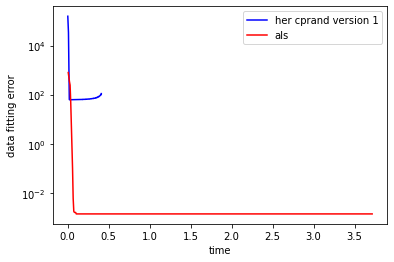

In [148]:
# her cprand version 1 data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

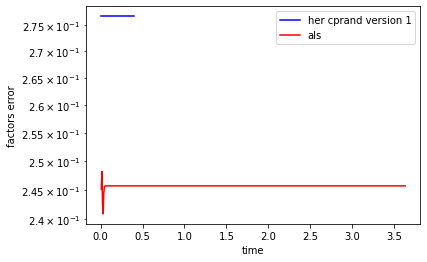

In [150]:
# her cprand version 1 factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

#### More complicated factors

##### her als

compare time ici, resultat different meme si j'ai mis set.seed ?

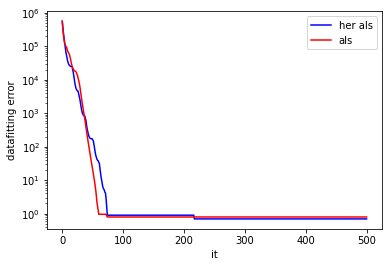

In [269]:
# her als data fitting error 
comparaison(I,J,K,r,nb_rand,n_samples,scale=True)

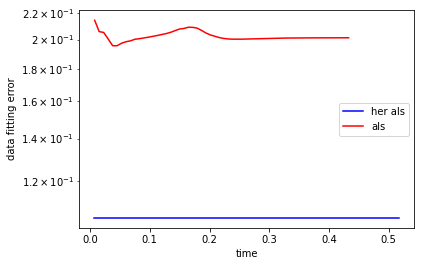

In [278]:
# her als data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

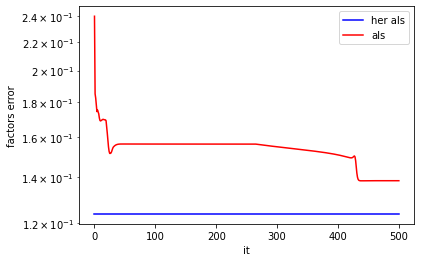

In [267]:
# her als factors error 
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

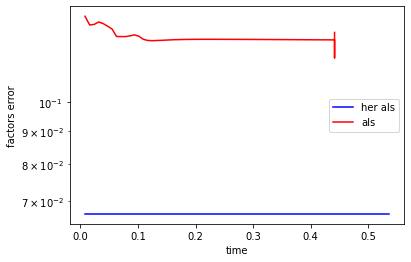

In [273]:
# her als facctors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

##### herCPRAND

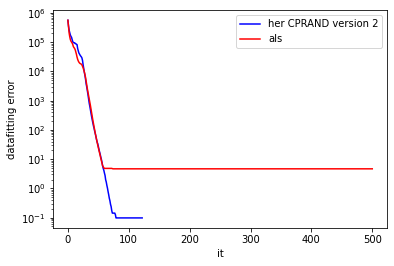

In [260]:
# her cprand version 2 data fitting error 
comparaison(I,J,K,r,nb_rand,n_samples,scale=True)

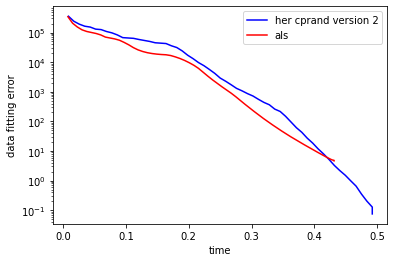

In [261]:
# her cprand version 2 data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples,scale=True)

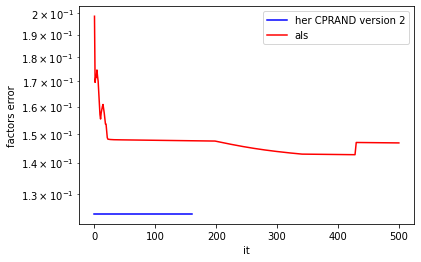

In [263]:
# her cprand version 2 factors error 
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

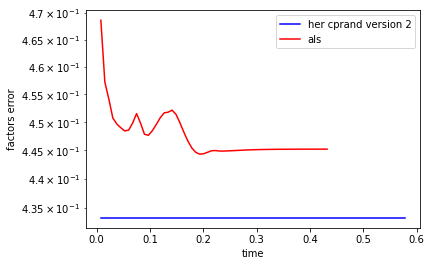

In [265]:
# her cprand version 2 factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)